In [1]:
%reset -f
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import os
import importlib
import vep_prob_models
import lib.plots.stan
import dyn_model
import retro_prepare_data

/home/anirudh/anaconda3/envs/python3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_dir = 'datasets/RetrospectivePatients/id004_bj'
results_dir = 'results/exp10/exp10.66.3/id004_bj'
meta_data_fname = 'BJcrise1le161128B-BEX_0002.json'
raw_seeg_fname = 'BJcrise1le161128B-BEX_0002.raw.fif'
# if os.path.isdir(results_dir):
#     os.rmdir(results_dir)
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)
os.makedirs(f'{results_dir}/Rfiles', exist_ok=True)

In [3]:
obs, consts, params_init = retro_prepare_data.prepare_data_pymc3(data_dir, results_dir, meta_data_fname, raw_seeg_fname, 10, 0.04)

Isotrak not found


In [4]:
obs['slp'] = obs['slp'][0:-1:1024]
obs['snsr_pwr'] = (obs['slp']**2).mean(axis=0)
obs['snsr_pwr'] = obs['snsr_pwr'] / obs['snsr_pwr'].max()

consts['nt'] = obs['slp'].shape[0]
consts['eps_snsr_pwr'] = 0.01

# params_init['alpha'] = 1.0

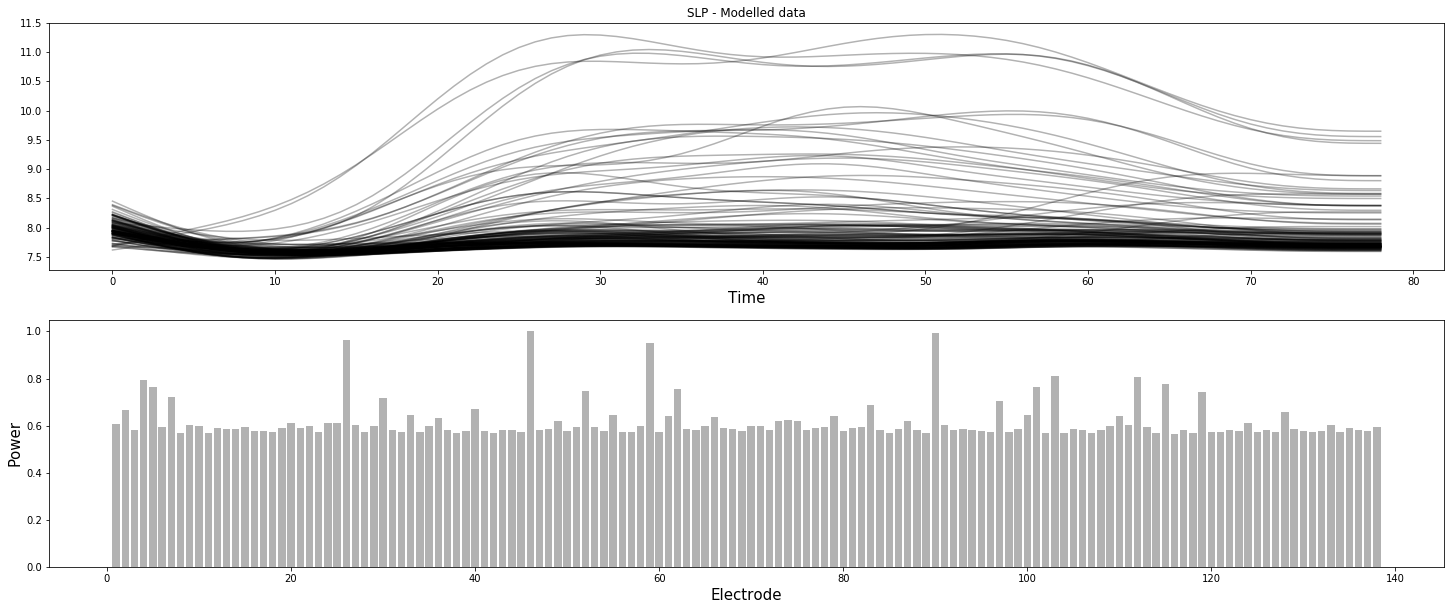

In [5]:
plt.figure(figsize=(25,10))
plt.subplot(211)
plt.plot(obs['slp'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=15)
plt.title('SLP - Modelled data')
plt.subplot(212)
plt.bar(np.arange(1,consts['gain'].shape[0]+1), obs['snsr_pwr'], color='black', alpha=0.3)
plt.xlabel('Electrode', fontsize=15)
plt.ylabel('Power', fontsize=15)
plt.savefig(f'{results_dir}/figures/fitting_data.png')

In [6]:
vep_mdl = vep_prob_models.vep_ode(consts=consts, obs=obs)

In [8]:
niters = 10000
optmzr = pm.SVGD(n_particles=4, jitter=0.1, temperature=1, model=vep_mdl.model, start=params_init)
post_approx = optmzr.fit(niters)
# trace = pm.sample(draws=500, start=params_init, tune=500, model=vep_mdl.model, chains=1)# nuts_kwargs={'target_accept':0.95, 'max_treedepth':15})

100%|██████████| 10000/10000 [25:25<00:00,  5.19it/s]


In [ ]:
try:
    i = 0
    while(True):
        print(f'Iterations {niters+i*100} - {niters+(i+1)*100}')
        optmzr.refine(100, progressbar=False)
        trace1 = optmzr.approx.sample(1000)
        i += 1
except FloatingPointError as err:
    pass

### Save the trace

In [ ]:
save_dir_name = 'samples'
os.makedirs(f'{results_dir}/{save_dir_name}')
pm.backends.save_trace(trace,f'{results_dir}/{save_dir_name}', overwrite=True)

In [ ]:
# trace = pm.backends.load_trace(f'{results_dir}', model=vep_mdl.model)
trace = np.load(f'{results_dir}/0/samples.npz')

In [9]:
with vep_mdl.model:
    trace = post_approx.sample(1000)

In [ ]:
with vep_mdl.model:
    trace = pm.backends.text.load(results_dir)

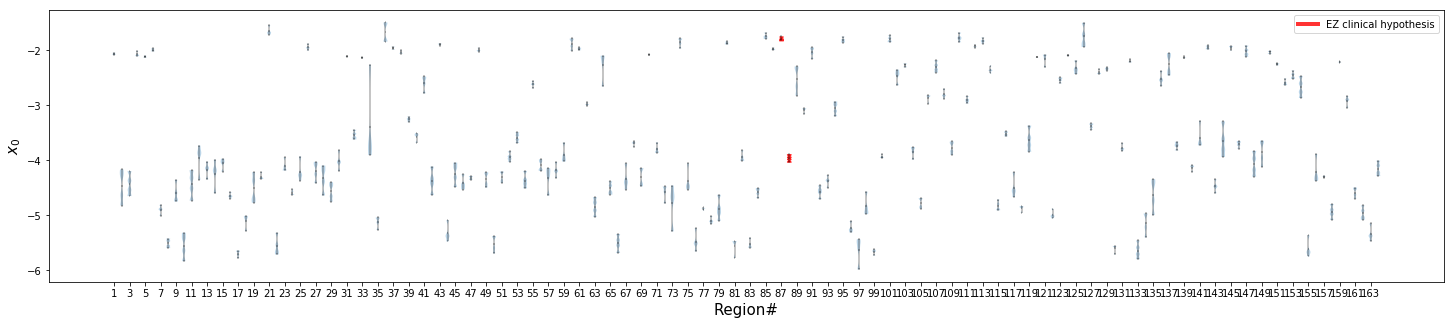

In [10]:
ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.destrieux.txt') == 1)[0] + 1

lib.plots.stan.x0_violin_patient(trace['x0'], ez_hyp, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin.png')

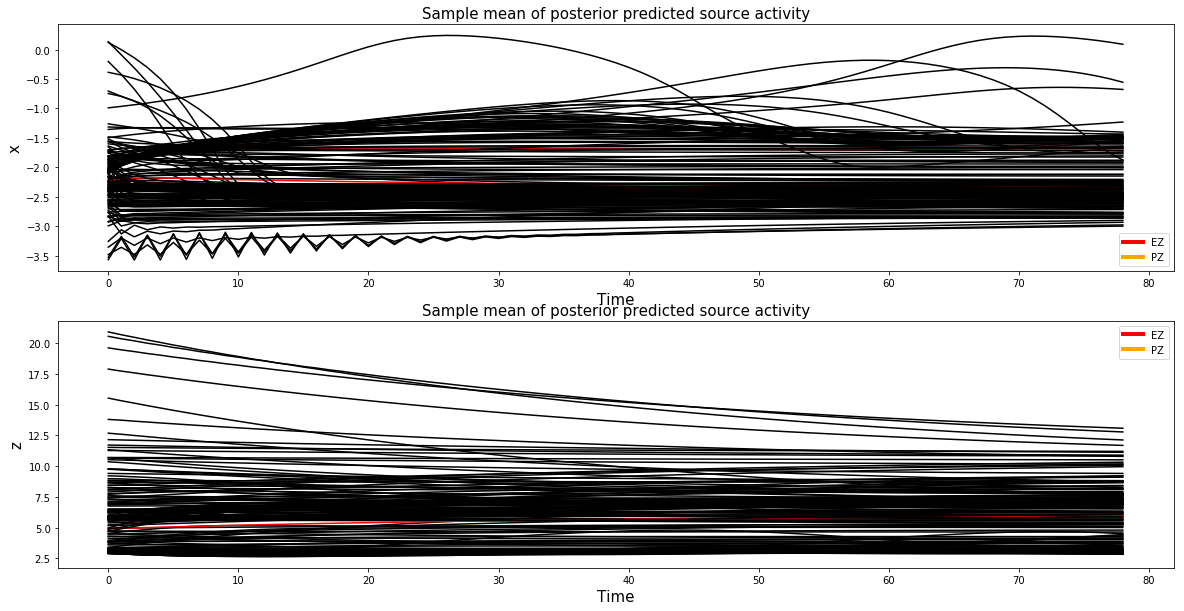

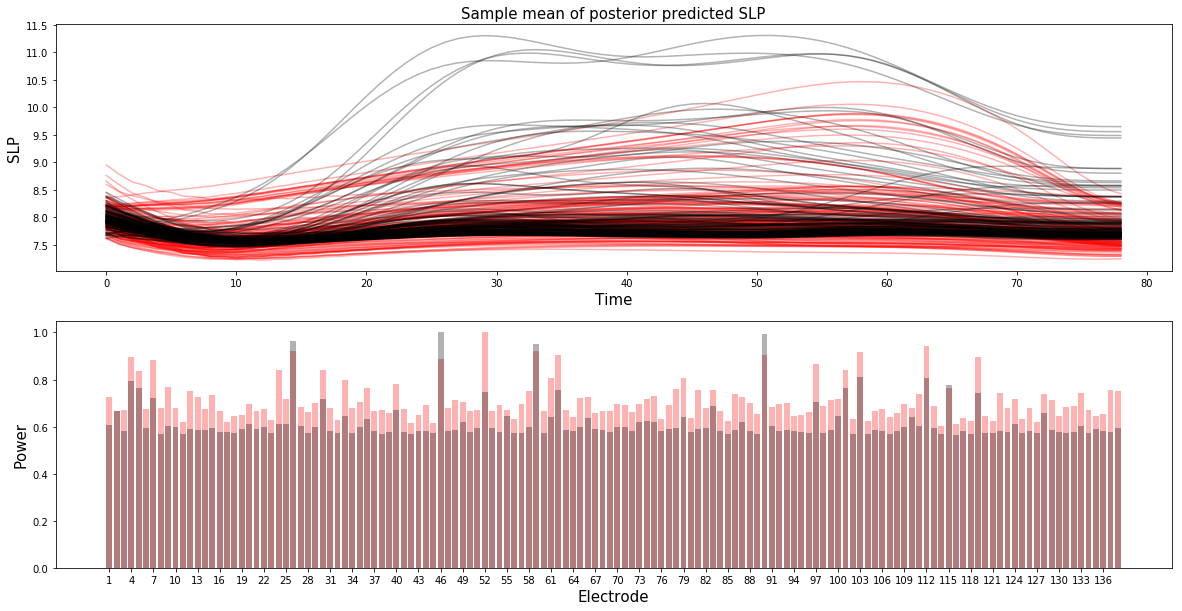

In [11]:
lib.plots.stan.plot_source(trace['x'].mean(axis=0), trace['z'].mean(axis=0), ez_hyp, [], figname=f'{results_dir}/figures/posterior_predicted_src.png')
lib.plots.stan.plot_fit_target({'slp':trace['mu_slp'].mean(axis=0), 'snsr_pwr':trace['mu_snsr_pwr'].mean(axis=0)}, obs, figname=f'{results_dir}/figures/posterior_predicted_slp.png')

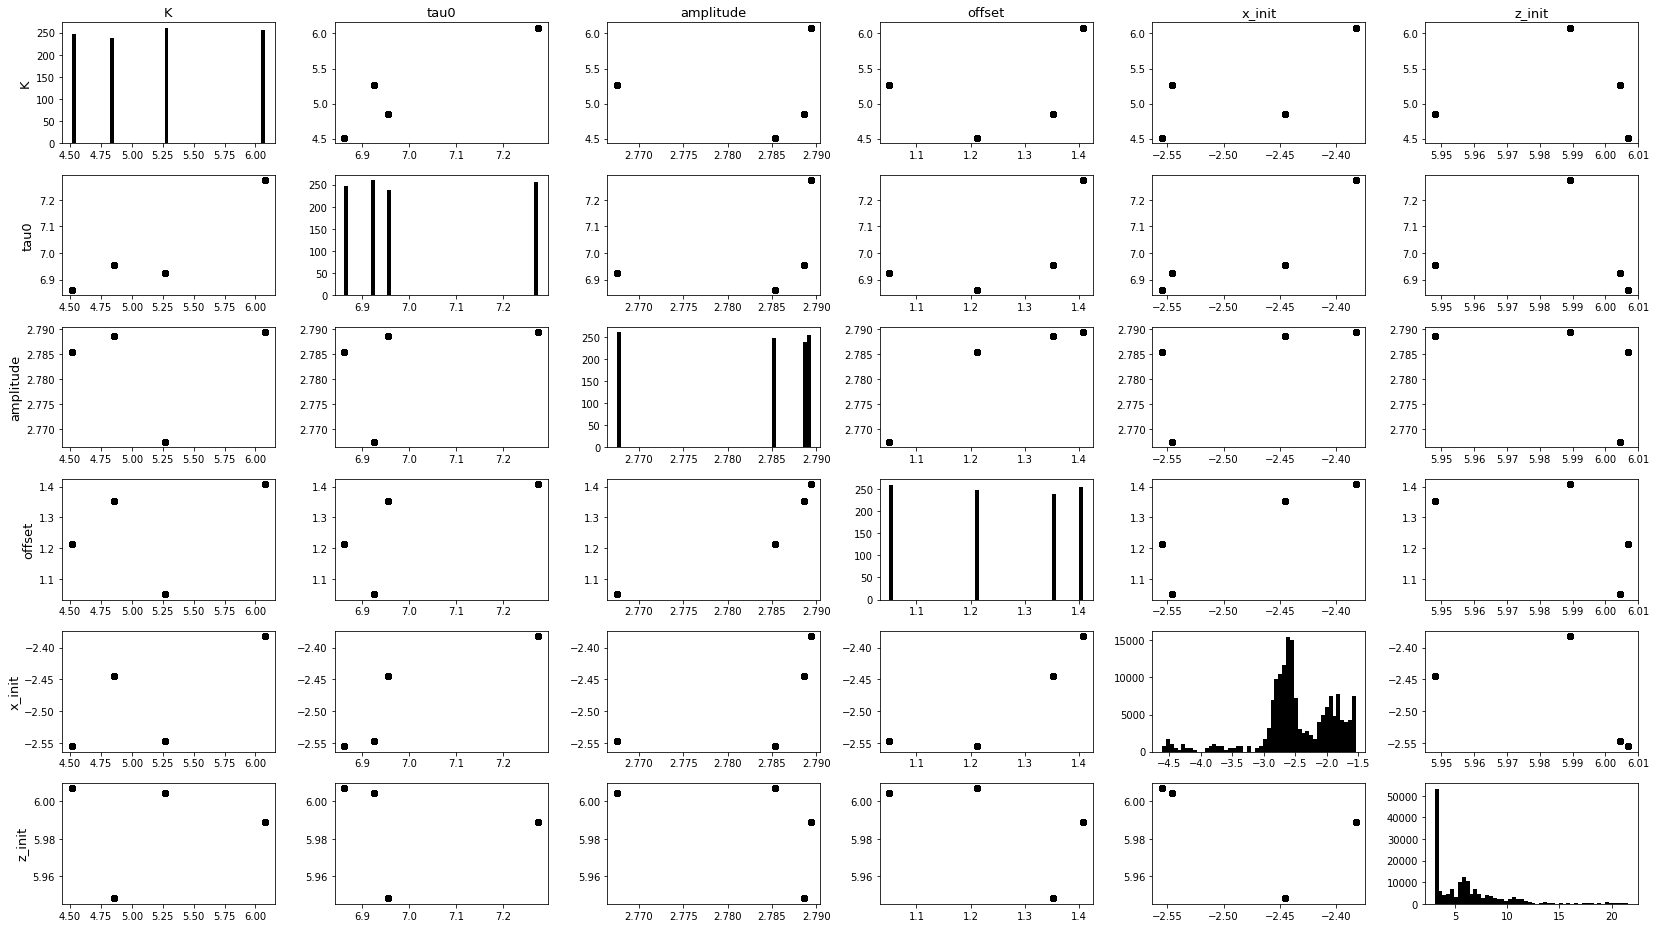

In [12]:
lib.plots.stan.pair_plots(trace, ['K', 'tau0', 'amplitude', 'offset', 'x_init', 'z_init'])

In [ ]:
post_pred = pm.sample_posterior_predictive(trace1, model=vep_mdl.model)

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(post_pred['slp'][20], 'r', alpha=0.3);
plt.plot(obs['slp'], 'k', alpha=0.3);
plt.figure(figsize=(25,5))
plt.bar(np.r_[0:consts['ns']], obs['snsr_pwr'], color='black', alpha=0.3)
plt.bar(np.r_[0:consts['ns']], trace1['mu_snsr_pwr'].mean(axis=0), color='red', alpha=0.5)

In [ ]:
ep = dyn_model.Epileptor_2D()
params = dict()
params['nn'] = consts['nn']
params['nt'] = consts['nt']
params['x_init'] = consts['x_init']
params['z_init'] = consts['z_init']
params['time_step'] = consts['time_step']
params['I1'] = consts['I1']
params['SC'] = consts['SC']
x = np.zeros((trace['x0'].shape[0], consts['nt'], consts['nn']))
z = np.zeros((trace['x0'].shape[0], consts['nt'], consts['nn']))
slp = np.zeros((trace['x0'].shape[0], consts['nt'], consts['ns']))
for i in range(trace['x0'].shape[0]):
    params['tau0'] = trace['tau0'][i]
    params['K'] = trace['K'][i]
    params['x0'] = trace['x0'][i]
    sim_out = ep.sim(params)
    x[i] = sim_out['x']
    z[i] = sim_out['z']
    slp[i] = trace['amplitude'][i]*(np.log(consts['gain']@np.exp(x[i].T)) + trace['offset'][i]).T

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(slp.mean(axis=0), 'k', alpha=0.3);